In [2]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import pickle
from matplotlib.ticker import MultipleLocator, FuncFormatter
import itertools

# Set the ticks as functions of pi
def pi_formatter(x, pos):
    fractions = {0: '0', np.pi/4: r'$\pi/4$', np.pi/2: r'$\pi/2$', 
                 3*np.pi/4: r'$3\pi/4$', np.pi: r'$\pi$'}
    return fractions.get(x, f_shear'{x/np.pi:.2g}π')

def plot_pdf_and_fit(alpha_values, noise, exponent):

    plt.figure(figsize=(10, 6))
    
    colormap = plt.cm.RdYlBu
    num_colors = len(alpha_values)
    extreme_indices = np.concatenate([
        np.linspace(0, 0.3, num_colors // 2, endpoint=False),  # Lower 30%
        np.linspace(0.7, 1.0, num_colors - num_colors // 2)    # Upper 30%
    ])
    colors = [colormap(i) for i in extreme_indices]
    
    # Insert a unique color for the central aspect ratio
    central_color = 'black'
    central_ap = 1.0  # Replace with the actual central value of aspect ratio
    
    try:
        central_index = alpha_values.index(central_ap)
    except ValueError:  # Raised if central_ap is not in alpha_values
        central_index = 0
    # Insert the central color
    colors.insert(central_index, central_color)
    # Plot the fit results
    for i, alpha in enumerate(alpha_values):
        # Solve the model with optimized parameters
        theta_x, model_solution = solve_for_alpha_fit(alpha, optimized_noise, optimized_exponent)
    
        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]
    
        # Plot the actual data
        plt.plot(actual_theta_x, actual_p, 'o', markersize = 0.5, label=f_shear"Actual Data (α = {alpha})", color=colors[i])
    
        # Plot the model solution
        plt.plot(theta_x, model_solution, '-', label=f_shear"Fit (α = {alpha})", color=colors[i])
    
    # Customize the plot
    plt.xlabel('$\\theta_x$ [rad]', fontsize=18)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=18)
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=np.pi/4))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    
    plt.title(f_shear'Circular PDF of Angular Distribution ($\\mu_p={cof}$, $I={I}$) and fit Fokker-Planck', fontsize=16)
    plt.grid(True)
    plt.show()

0.2449797437097597
0.0856193126260577 0.2449797437097597 0.6616433603561477
0.17442682283848407
0.14530878249214202 0.17442682283848407 0.7207772223994833
0.11978724383395296
0.18441467053226795 0.11978724383395296 0.751846895758631
0.07835732837377427
0.20802767484556953 0.07835732837377427 0.7636587429282852
0.04851368162289431
0.22078181940922748 0.04851368162289431 0.7639832987268779
0.0287027457518646
0.22660565263495724 0.0287027457518646 0.7590956430008284
0.01696636616800259
0.22852864588100072 0.01696636616800259 0.7531554278727277
0.011016429309196977
0.2286182446212262 0.011016429309196977 0.7483352972667967
0.008650516177276586
0.22808569756719022 0.008650516177276586 0.7452474753321012
0.008142701960860555
0.22751241000447864 0.008142701960860555 0.7436231241454285
0.008383100820527595
0.22709893199178166 0.008383100820527595 0.7429633058741982
0.008788870189458299
0.22686118218537127 0.008788870189458299 0.7428098489744749
0.009123993189704313
0.22675098149981437 0.009123

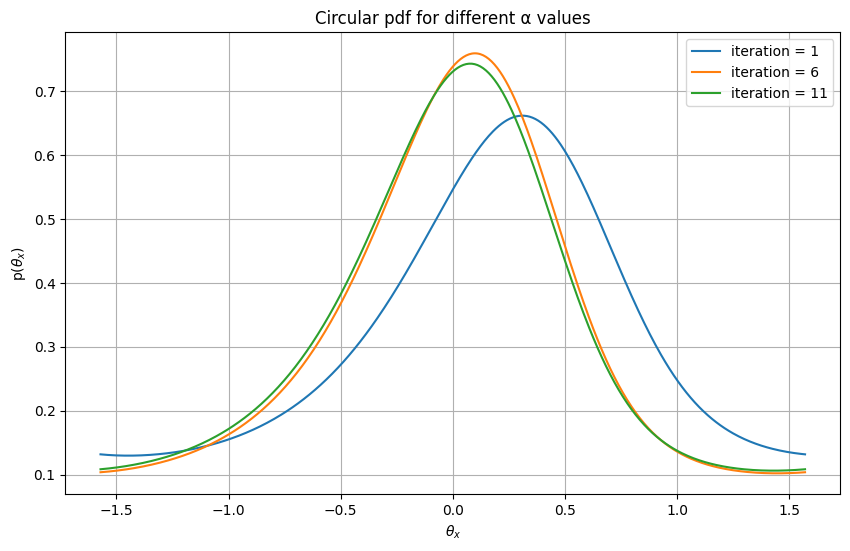

In [84]:
import numpy as np
from scipy.integrate import solve_bvp

# Define parameters
Gamma = 1.0
U0 = 1.0
tol = 1e-4  # Convergence tolerance
max_iter = 50  # Maximum fixed-point iterations
alpha_value = 3.0
noise = 0.1
c=1

# Define Beta function
def Beta(alpha):
    return (alpha**2 - 1) / (alpha**2 + 1)

# Define f_shear function (including Maier-Saupe term)
def f_shear(theta_x, alpha, S, theta_d):
    return -Gamma / 2 * (1.0 - Beta(alpha) * np.cos(2 * theta_x)) - U0 * S * np.sin(2 * (theta_x-theta_d))

# ODE function
def ode(theta_x, p, alpha, S, theta_d, noise):
    dp_dtheta_x = (f_shear(theta_x, alpha, S, theta_d) * p[0]+c) /noise 
    return np.array([dp_dtheta_x])

# Boundary conditions
def boundary_conditions(p_start, p_end):
    return np.array([p_start[0] - p_end[0]])

# Compute nematic order parameters
def compute_order_params(theta_x, p_values, theta_old, S_old):
    """Computes nematic order parameter S and director theta_d from solution."""
    # Compute director theta_d as circular mean
    # theta_d = 0.5 * np.arctan2(
    #     np.trapezoid(np.sin(2 * theta_x) * p_values, theta_x),
    #     np.trapezoid(np.cos(2 * theta_x) * p_values, theta_x)
    # )

    # Compute S = ⟨cos(2θ)⟩
    S = np.trapezoid(np.cos(2 * (theta_x)) * p_values, theta_x)

    sin2t = np.trapezoid(np.sin(2 * theta_x) * p_values, theta_x)
    cos2t = np.trapezoid(np.cos(2 * theta_x) * p_values, theta_x)

    theta_d = 0.5*np.arctan2(sin2t, cos2t)
    print(theta_d)

    delta = 0.5
    S = (delta*S + S_old) / 2 # Average with previous value
    # theta_d = (delta*theta_d + theta_old) / 2 # Average with previous value

    return S, theta_d

# Solver function with fixed-point iteration
def solve_fixed_point(alpha_value, noise):
    """Solves the BVP iteratively updating S and theta_d."""
    
    # Define the theta_x range (ensure it's strictly increasing)
    theta_x = np.linspace(-np.pi / 2, np.pi / 2, 500)
    
    # Initial guess
    initial_guess = np.ones((1, theta_x.size))
    
    # Initial conditions
    S = 0.0
    theta_d = 0.0
    plt.figure(figsize=(10, 6))
    
    for i in range(max_iter):
        # Solve BVP with current S and theta_d
        sol = solve_bvp(
            lambda theta_x, p: ode(theta_x, p, alpha_value, S, theta_d, noise),
            boundary_conditions,
            theta_x,
            initial_guess
        )

        if not sol.success:
            raise RuntimeError("BVP solver failed to converge")

        # Normalize the solution
        p_values = sol.sol(theta_x)[0]
        p_values /= np.trapezoid(p_values, theta_x)  # Normalize
        
        # Compute new S and theta_d
        new_S, new_theta_d = compute_order_params(theta_x, p_values, theta_d, S)

        # Check convergence
        if np.abs(new_S - S) < tol and np.abs(new_theta_d - theta_d) < tol:
            print(f_shear"Converged after {i} iterations.")
            return theta_x, p_values, new_S, new_theta_d
        
        # Update for next iteration
        S, theta_d = new_S, new_theta_d

        print(S, theta_d, np.max(p_values))

        # Update initial guess with the current solution to improve convergence
        initial_guess = np.array([p_values])
        if i % 5 == 0:
            plt.plot(theta_x, p_values, label=f_shear"iteration = {i+1}")
   
        plt.xlabel("$\\theta_x$")
        plt.ylabel("p($\\theta_x$)")
        plt.title("Circular pdf for different α values")
        plt.legend()
        plt.grid(True)
    plt.show()

    raise RuntimeError("Fixed-point iteration did not converge within max iterations.")

theta_x, p_solution, S_final, theta_d_final = solve_fixed_point(alpha_value, noise)

print(f_shear"Final nematic order parameter: S = {S_final}")
print(f_shear"Final director angle: θ_d = {theta_d_final}")

7.499771008473433e-06 0.0019999168699664028
7.49972516445041e-06 0.001999916892676685
7.4997653325692415e-06 0.0019999168209964935
7.499819586337386e-06 0.001999916827440424
7.499783253206438e-06 0.0019999169057463738
7.499757138956786e-06 0.0019999168533098447
7.499770908275805e-06 0.0019999168933691742
7.499814440453667e-06 0.001999916938117348
7.499822224255048e-06 0.0019999168525664532
7.499767080032527e-06 0.0019999169590201767
7.499749808348444e-06 0.001999916891410261
7.499805749600075e-06 0.00199991683922758
7.499784265313503e-06 0.001999916868198619
7.499794808935034e-06 0.0019999168402151024
7.499803419130924e-06 0.0019999168829245716
7.499780500103137e-06 0.0019999168829559462
7.499763088447686e-06 0.0019999168739329052
7.4997539268595315e-06 0.001999916935107285
7.4998650034519e-06 0.0019999168875781867
7.499771373126185e-06 0.0019999168768932343
7.49976052652479e-06 0.0019999168424731316
7.499767711915961e-06 0.0019999169390693596
7.499868509980301e-06 0.001999916882971196

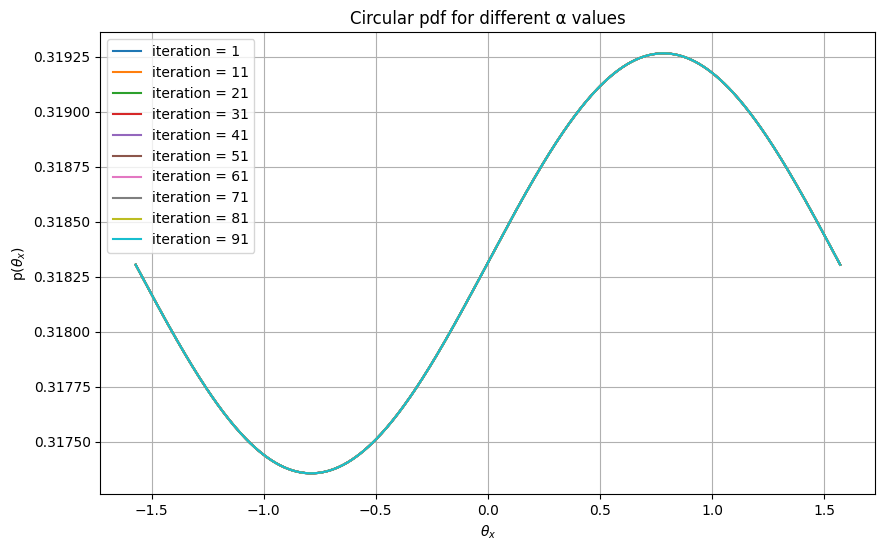

RuntimeError: Fixed-point iteration did not converge within max iterations.

In [7]:
import numpy as np
from scipy.integrate import solve_bvp

# Define parameters
Gamma = 0.02
U0 = .5
tol = 1e-4  # Convergence tolerance
max_iter = 100  # Maximum fixed-point iterations
alpha_value = 2.0
noise = 1.0
c=1
S = 0.5

# Define Beta function
def Beta(alpha):
    return (alpha**2 - 1) / (alpha**2 + 1)

# Define f_shear function
def f_shear(theta_x, alpha):
    return - Gamma / 2 * (1.0 - Beta(alpha) * np.cos(2 * (theta_x))) 

# Meier-Saupe potential
def f_saupe(theta_x, avg_cos_ttheta, avg_sin_ttheta):
    #return - U0 * S * np.sin(2*(theta_x-theta_d))
    return -U0*(avg_cos_ttheta*np.cos(2*theta_x) + avg_sin_ttheta*np.sin(2*theta_x))

# ODE function
def ode(theta_x, p, alpha, S, theta_d, noise):
    dp_dtheta_x = (f_shear(theta_x, alpha) * p[0]+c) /noise 
    return np.array([dp_dtheta_x])

# Boundary conditions
def boundary_conditions(p_start, p_end):
    return np.array([p_start[0] - p_end[0]])

# Compute nematic order parameters
def compute_order_params(theta_x, p_values, theta_old, S_old):
    """Computes nematic order parameter S and director theta_d from solution."""
    # Compute director theta_d as circular mean
    # theta_d = 0.5 * np.arctan2(
    #     np.trapezoid(np.sin(2 * theta_x) * p_values, theta_x),
    #     np.trapezoid(np.cos(2 * theta_x) * p_values, theta_x)
    # )

    # Compute S = ⟨cos(2θ)⟩
    S = np.trapezoid(np.cos(2 * (theta_x)) * p_values, theta_x)

    # find the mean angle
    mean_theta = np.arctan2(np.trapezoid(np.sin(theta_x) * p_values, theta_x), np.trapezoid(np.cos(theta_x) * p_values, theta_x))
    
    sin2t = np.trapezoid(np.sin(2 * theta_x) * p_values, theta_x)
    cos2t = np.trapezoid(np.cos(2 * theta_x) * p_values, theta_x)

    theta_d = 0.5*np.arctan2(sin2t, cos2t)
    theta_d = mean_theta

    delta = 0.5
    # S = (delta*S + S_old) / 2 # Average with previous value
    S = S_old
    theta_d = (delta*theta_d + theta_old) / 2 # Average with previous value

    return S, theta_d

# Solver function with fixed-point iteration
def solve_fixed_point(alpha_value, noise):
    """Solves the BVP iteratively updating S and theta_d."""
    
    # Define the theta_x range (ensure it's strictly increasing)
    theta_x = np.linspace(-np.pi / 2, np.pi / 2, 500)
    
    # Initial guess
    initial_guess = np.ones((1, theta_x.size))
    
    # Initial conditions
    S = 0.7
    theta_d = 0.0
    plt.figure(figsize=(10, 6))
    
    for i in range(max_iter):
        # Solve BVP with current S and theta_d
        sol = solve_bvp(
            lambda theta_x, p: ode(theta_x, p, alpha_value, S, theta_d, noise),
            boundary_conditions,
            theta_x,
            initial_guess
        )

        if not sol.success:
            raise RuntimeError("BVP solver failed to converge")

        # Normalize the solution
        p_values = sol.sol(theta_x)[0]
        p_values /= np.trapezoid(p_values, theta_x)  # Normalize
        
        # Compute new S and theta_d
        new_S, new_theta_d = compute_order_params(theta_x, p_values, theta_d, S)

        # compute S from theta_x
        S_computed = np.trapezoid(np.cos(2 * (theta_x)) * p_values, theta_x)

        theta_d_computed = np.arctan2(np.trapezoid(np.sin(theta_x) * p_values, theta_x), np.trapezoid(np.cos(theta_x) * p_values, theta_x))

        # Check convergence
        if np.abs(new_S - S_computed) < tol and np.abs(new_theta_d - theta_d) < tol:
            print(f"Converged after {i} iterations.")
            return theta_x, p_values, new_S, new_theta_d
        
        # Update for next iteration
        S, theta_d = new_S, new_theta_d

        print(S_computed, theta_d_computed)

        # Update initial guess with the current solution to improve convergence
        initial_guess = np.array([p_values])
        if i % 10 == 0:
            plt.plot(theta_x, p_values, label=f"iteration = {i+1}")
   
        plt.xlabel("$\\theta_x$")
        plt.ylabel("p($\\theta_x$)")
        plt.title("Circular pdf for different α values")
        plt.legend()
        plt.grid(True)
    plt.show()

    raise RuntimeError("Fixed-point iteration did not converge within max iterations.")

theta_x, p_solution, S_final, theta_d_final = solve_fixed_point(alpha_value, noise)

print(f"Final nematic order parameter: S = {S_final}")
print(f"Final director angle: θ_d = {theta_d_final}")